<a href="https://colab.research.google.com/github/thiagomantuani/svm-especies-madeira-amazonia/blob/master/svm_madeira_amazonia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classificação de espécies de madeira comercializada na Amazônia Legal.


*   O Problema consiste em classificar 19 espécies de madeira mais comercializada na amazônia legal utilizando SVM.

![texto alternativo](https://drive.google.com/uc?export=view&id=1xTQ31lr2ua6kez1jX49zaHz16LPIQRBU)



In [ ]:
!pip install Pillow
!pip install tqdm
!pip install scikit-optimize

In [ ]:
from google.colab import drive
import numpy as np
from PIL import Image
from tqdm import tqdm_notebook as tqdm
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
from sklearn.metrics import (confusion_matrix, classification_report,accuracy_score, precision_score)
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from time import sleep

In [ ]:
%matplotlib inline

In [ ]:
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


diretório onde se encontra as imagens

In [ ]:
path = '/gdrive/My Drive/DataSets/especies'
os.chdir(path)
print(path)

/gdrive/My Drive/DataSets/especies


In [ ]:
class MyException(Exception):
    pass

Visualização das amostras de madeira

In [ ]:
def plot_especies():
        
    imgs=[]
    name=[]
    for _,_,file in os.walk(path):
        for img in file:            
            if img.split('.')[1] == 'jpg':      
              im = Image.open(path+'/'+img,'r')
              imgs.append(im)
              name.append(img.split('.')[0])
              
    fig, axs = plt.subplots(5, 4, figsize=(12, 10))
    axs = axs.flatten()
    for img, ax, title in zip(imgs, axs, name):
        ax.imshow(img)
        ax.set_title(title)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)        
    fig.delaxes(axs[19])
    fig.canvas.draw()
    plt.tight_layout()
    plt.show()

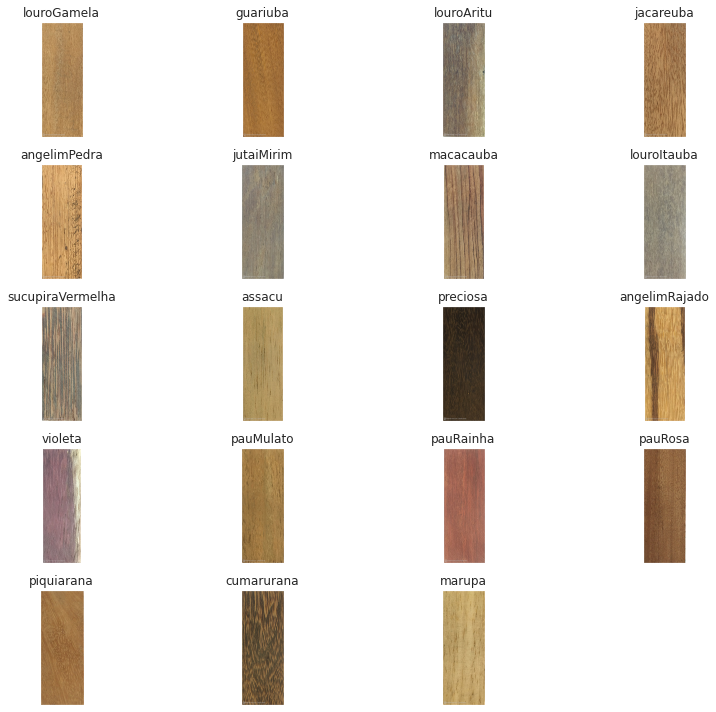

In [ ]:
plot_especies()

# **Carregamento das imagens**



*   Transformação para RGB.
*   Extraindo 100 amostras de cada espécie, totalizando em 1900 amostras.
*   Serão extraídas as seguintes informações:
    *   **Média dos pixels (RGB)** -> mr (media red), mg (media green), mb (media blue)
    *   **Desvio padrão (RGB)** -> dr (desvio red), dg (desvio green), db (desvio blue)
    *   **Coeficiente de variação** -> cvr (coeficiente red), cvg (coeficiente green), cvb (coeficiente blue):
    *   **Quartil** -> q1r (primeiro quartil pixel red), q1g (primeiro quartil pixel green), q1b (primeiro quartil pixel blue), q2r...
    *   **target** = Espécie a ser classificada








In [ ]:
def get_data():
   
  try:
      if not os.path.isdir(path):
          raise MyException('Não existe o diretorio de imagens ''especies''')
      elif len(os.listdir(path)) == 0:
          raise MyException('Nenhum arquivo de imagem encontrado no diretorio: ',path) 
      elif os.path.exists('dados_especies.csv'):
          print('excluindo arquivo dados_especies.csv')
          os.remove('dados_especies.csv')                  
      
      pixel_por_especie = []
      df = pd.DataFrame()
      for _,_,file in os.walk(path):
          for img in tqdm(file,total=len(file),desc='Extraindo 100 amostras de cada especie.',
                          leave=True, position=0):       
              if img.split('.')[1] == 'jpg':                                          
                  classe = img.split('.')[0]                                                                      
                  im = Image.open(path+'/'+img,'r')
                  pixel = list(im.getdata()) 
                  array_pixel = np.asarray(pixel)                      
                  amostras = np.array_split(array_pixel,100)  
                  pixel_por_especie.append((classe,len(pixel)))                  
                  especie = []
                  for i in amostras:
                      mean_ = i.mean(axis=0).reshape(1,-1)
                      desv_ = i.std(axis=0).reshape(1,-1)
                      cv    = 100*(desv_/mean_)
                      q1    = np.quantile(i,.25,axis=0).reshape(1,-1)
                      q2    = np.quantile(i,.50,axis=0).reshape(1,-1)
                      q3    = np.quantile(i,.75,axis=0).reshape(1,-1)
                      
                      
                      especie.append(np.column_stack((mean_,desv_,cv,q1,q2,q3,classe)))
                      
                  data = np.concatenate(especie)
                  df = df.append(list(data))                                    
                  sleep(0.03)
      df.rename(columns={0:'mr',1:'mg',2:'mb',
                          3:'dr',4:'dg',5:'db',
                          6:'cvr',7:'cvg',8:'cvb',
                          9:'q1r',10:'q1g',11:'q1b',
                          12:'q2r',13:'q2g',14:'q2b',
                          15:'q3r',16:'q3g',17:'q3b',
                          18:'target'},inplace=True)

      print('gerando arquivo dados_especies.csv')
      df.to_csv('dados_especies.csv',index=None)
      print('arquivo dados_especies.csv gerado')
      
    
      return df, pixel_por_especie
  
  except Exception as e:
      raise e    

# **Visualização dos dados**

In [ ]:
df, pixel_por_especie = get_data()

excluindo arquivo dados_especies.csv


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  app.launch_new_instance()



gerando arquivo dados_especies.csv
arquivo dados_especies.csv gerado


In [ ]:
df_pixel_especie = pd.DataFrame(data=pixel_por_especie,columns=['Especie','qtd_pixel'])

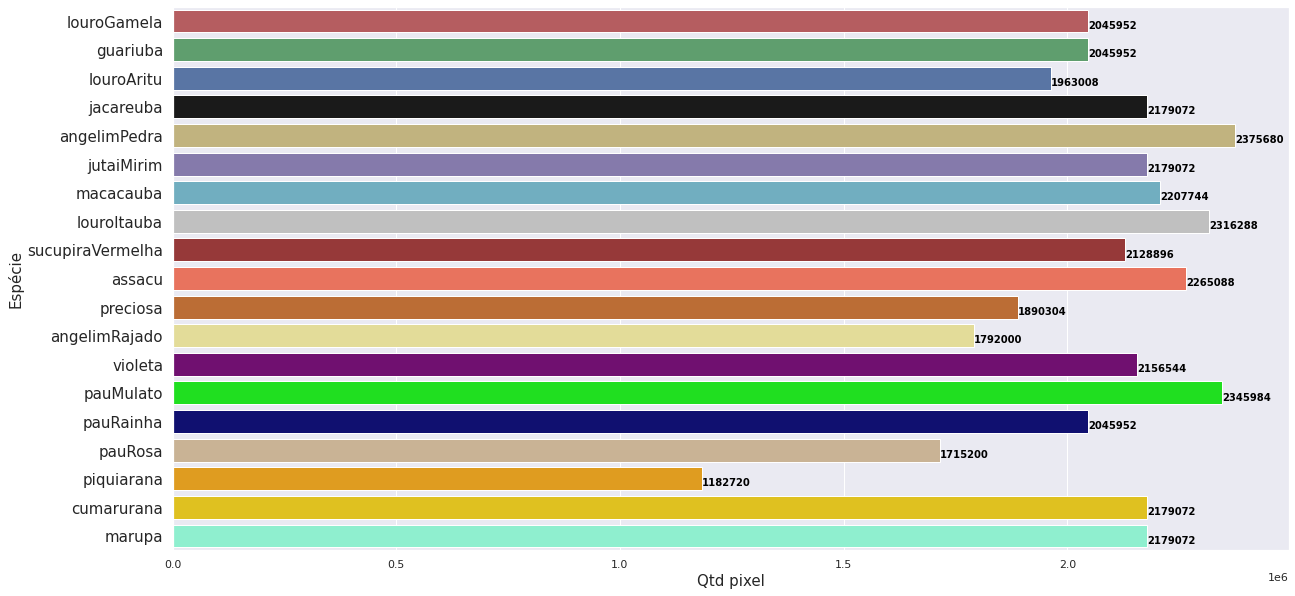

In [ ]:
colors = ['r', 'g', 'b', 'k', 'y', 'm', 'c','silver','brown','tomato','chocolate',
          'khaki','purple','lime','navy','tan','orange','gold','aquamarine']
fig, ax = plt.subplots(figsize=(20,10))
sns.set_style('whitegrid')
sns.barplot(x='qtd_pixel',y='Especie',data=df_pixel_especie,ax=ax,palette=colors)
ax.set_yticklabels(df_pixel_especie.Especie,rotation=0)
for i, v in enumerate(df_pixel_especie.qtd_pixel.values):
  ax.text(v + 3, i+.25, str(v), color='black', fontweight='bold')
ax.set_xlabel('Qtd pixel',size=15)
ax.set_ylabel('Espécie',size=15)
ax.set_yticklabels(labels=[e for e in df_pixel_especie.Especie.values],size=15)

plt.show()

Amostragem de 10 registros do dataset

In [ ]:
df.sample(frac=1).head(10)

,mr,mg,mb,dr,dg,db,cvr,cvg,cvb,q1r,q1g,q1b,q2r,q2g,q2b,q3r,q3g,q3b,target
69,107.63732733697398,85.4354550043596,56.05974943784131,21.816091479854702,16.33193465996032,10.868968149943536,20.268146766182998,19.11610894929621,19.38818538958148,91.0,73.0,48.0,102.0,81.0,54.0,125.0,98.0,63.0,cumarurana
27,106.8811894818962,83.0842549676472,55.08411729613143,26.219313624448844,20.1627508050288,12.212895888487333,24.531270424240496,24.267836081433387,22.17135626015568,84.0,66.0,46.0,102.0,78.0,53.0,129.0,100.0,64.0,cumarurana
64,163.52237162131155,122.91739709054197,78.70171171584599,15.584929874173355,15.996754803123231,13.953282756441386,9.530763111891046,13.014231656190939,17.72932564264927,154.0,113.0,70.0,165.0,125.0,80.0,175.0,135.0,89.0,jacareuba
42,135.1603311567164,95.90543376865672,62.4209421641791,17.505551307212297,17.900593261980948,15.485991347997071,12.951693116906371,18.664837390924895,24.80896764945638,122.0,83.0,52.0,135.0,96.0,62.0,148.0,108.0,72.0,pauRosa
71,147.96265595993611,141.88075810559945,126.05603764624617,11.517968066009468,12.109176563911378,12.114171541835383,7.784375044692488,8.534756034288119,9.610147810477471,140.0,133.0,117.0,148.0,142.0,126.0,156.0,150.0,133.0,louroItauba
3,153.02573069118853,144.57350084185987,127.3018607261581,8.159979926199476,8.148323914212177,7.139585542962675,5.332423435811989,5.636111643395238,5.608390562586354,147.0,139.0,122.0,153.0,144.0,127.0,159.0,150.0,132.0,louroItauba
55,157.28894041270578,131.25277069325296,130.37111059587295,24.249176582106916,31.67071710076011,22.092438013598834,15.416962259698755,24.129560795921652,16.945807942130237,144.0,113.0,118.0,149.0,118.0,122.0,158.0,131.0,132.0,violeta
14,192.9033545959341,164.0453398191914,104.16277362213758,9.650941701593252,9.975370532802279,10.065157925446028,5.002993194083452,6.080861878671469,9.662912742664231,187.0,158.0,98.0,193.0,164.0,105.0,200.0,171.0,111.0,marupa
63,150.23136035919353,145.26913612226394,129.17778353408454,12.142033026486196,12.535181600872798,13.546480729504461,8.082222644762968,8.628936562493715,10.486695435465588,142.0,137.0,120.0,149.0,144.0,127.0,158.0,153.0,136.0,louroItauba
2,163.50718475073313,109.74672531769306,95.07199413489737,9.155920860065558,6.0939834221130225,5.579133694227872,5.599705526105027,5.5527701664648825,5.868325099304908,158.0,106.0,91.0,164.0,110.0,95.0,169.0,113.0,99.0,pauRainha


In [ ]:
df.dtypes

mr        object
mg        object
mb        object
dr        object
dg        object
db        object
cvr       object
cvg       object
cvb       object
q1r       object
q1g       object
q1b       object
q2r       object
q2g       object
q2b       object
q3r       object
q3g       object
q3b       object
target    object
dtype: object

In [ ]:
classes_ = np.unique(df.target)

converter dados de entrada para float

In [ ]:
for col in df.columns:
  if col != 'target':
    df[col] = df[col].astype(float)

Verificando quantidade de amostras de cada espécie

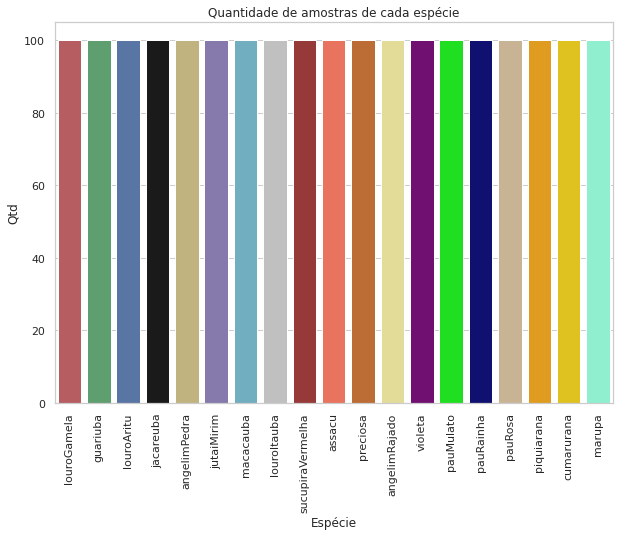

In [ ]:
colors = ['r', 'g', 'b', 'k', 'y', 'm', 'c','silver','brown','tomato','chocolate',
          'khaki','purple','lime','navy','tan','orange','gold','aquamarine']
fig, ax = plt.subplots(1,figsize=(10,7))
sns.set_style('darkgrid')
sns.countplot(df['target'],ax=ax,palette=colors)
ax.set_title('Quantidade de amostras de cada espécie')
ax.set_xlabel('Espécie')
ax.set_ylabel('Qtd')
ax.set_xticklabels(labels=df.target.unique(),rotation=90)
plt.show()

Gráficos de distribuição das variáveis

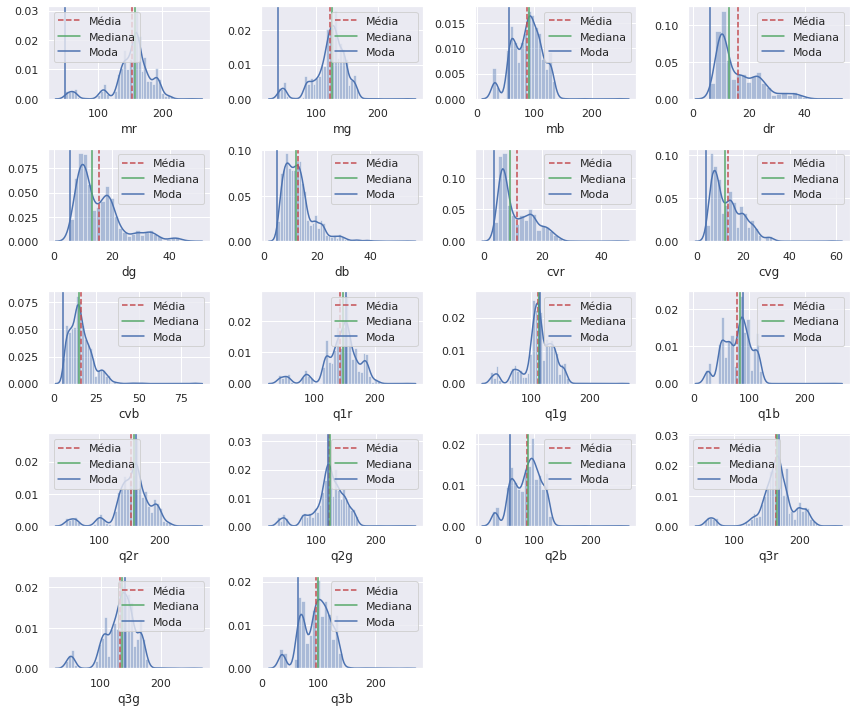

In [ ]:
fig, ax = plt.subplots(5,4,figsize=(12,10))
axs = ax.flatten()
for col, ax in zip(df.columns, axs):
    if col not in ['target']:
      mean = df[col].mean()
      median = df[col].median()
      mode = df[col].mode()[0]
      sns.distplot(df[col],ax=ax)
      ax.axvline(mean, color='r', linestyle='--',label='Média')
      ax.axvline(median, color='g', linestyle='-',label='Mediana')
      ax.axvline(mode, color='b', linestyle='-',label='Moda')
      ax.legend()
fig.delaxes(axs[19])
fig.delaxes(axs[18])

plt.tight_layout()
plt.show()

In [ ]:
df_complete = df.copy()

# **Pré-processamento**


*   Transformação da coluna target para numérico.
*   Colocando os dados de entrada na mesma escala.


**Padronização:**
A padronização fará com que as variáveis fiquem com média 0 e desvio padrão 1

![texto alternativo](https://drive.google.com/uc?export=view&id=1-2ar2WaxCNsmb9i03zkAig2MTlsCgxZ8)



**Normalização:**

![texto alternativo](https://drive.google.com/uc?export=view&id=1zNLs6O0OHjjEgGBwn9bWM2QQWHfxf8Fg)


Nos testes a padronização obteve um melhor resultado, dessa forma será utilizado a padronização.

In [ ]:
lblencoder = LabelEncoder()

In [ ]:
def preprocess(df,pType='padronize'):
    dfproc = df.copy()
        
    
    # pradronizando/normalizando os dados de entrada, transformando todas na mesma ordem de grandeza
    df_complete['especie'] = dfproc['target']
    dfproc['target'] = lblencoder.fit_transform(dfproc['target'].values) 
    df_complete['target']  = lblencoder.fit_transform(dfproc['target'].values) 
    for col in dfproc.columns:
        if col != 'target':
            if pType=='normalize':
              dfproc[col] = MinMaxScaler().fit_transform(dfproc[col].values.reshape(-1,1))
            else:
              dfproc[col] = StandardScaler().fit_transform(dfproc[col].values.reshape(-1,1))
      
    dfproc = dfproc.sample(frac=1) #embaralhar os dados
    return dfproc    


função responsável por dividir os dados em treino, teste e validação

In [ ]:
def train_validate_test_split(x,y,pStratify=True):
    # 70% treinamento = 1330
    # 20% teste      = 380
    # 10% validacao  = 190    
    x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2,stratify=y if pStratify else None)
    
    x_train, x_validate, y_train, y_validate = train_test_split(x_train,y_train, test_size=0.125,stratify=y_train if pStratify else None)

    return x_train, x_test, x_validate, y_train, y_test, y_validate

In [ ]:
def train_validate_test_split_random(data):
    # 70% treinamento = 1330
    # 20% teste      = 380
    # 10% validacao  = 190
    df_split = data.copy()
    train, validate, test = np.split(df_split.sample(frac=1), [int(0.7*len(df)), int(0.8*len(df_split))])    
    return train, validate, test

In [ ]:
def split_dataset(pDf):

  dfsplit = pDf.copy()
  train, valid, test = train_validate_test_split_random(dfsplit)

  x_train = train.drop(columns=['target']).values
  y_train = train.target.values

  x_test = test.drop(columns=['target']).values
  y_test = test.target.values

  x_val = valid.drop(columns=['target']).values
  y_val = valid.target.values
  
  return x_train,x_test,x_val,y_train,y_test,y_val

In [ ]:
df = preprocess(df,'padronize')

x_train, x_test, x_val, y_train, y_test, y_val =\
  split_dataset(df)  

In [ ]:
# qtd de registros de cada especie no conjunto de dados de treinamento
np.unique(y_train,return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18]),
 array([70, 67, 74, 69, 66, 70, 71, 67, 72, 69, 73, 69, 74, 66, 71, 67, 75,
        67, 73]))

In [ ]:
# qtd de registros de cada especie no conjunto de dados de teste
np.unique(y_test,return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18]),
 array([17, 25, 18, 20, 28, 16, 16, 21, 15, 19, 16, 25, 16, 20, 23, 22, 17,
        26, 20]))

In [ ]:
# qtd de registros de cada especie no conjunto de dados de validação
np.unique(y_val,return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18]),
 array([13,  8,  8, 11,  6, 14, 13, 12, 13, 12, 11,  6, 10, 14,  6, 11,  8,
         7,  7]))

# Criando uma baseline para comparação com demais modelos

In [ ]:
model_baseline = SVC(kernel='rbf',gamma=0.007)

model_baseline.fit(x_train, y_train)
y_pred = model_baseline.predict(x_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97        17
           1       0.96      1.00      0.98        25
           2       0.95      1.00      0.97        18
           3       1.00      1.00      1.00        20
           4       0.93      1.00      0.97        28
           5       1.00      0.94      0.97        16
           6       1.00      1.00      1.00        16
           7       1.00      1.00      1.00        21
           8       1.00      0.87      0.93        15
           9       1.00      1.00      1.00        19
          10       0.88      0.94      0.91        16
          11       1.00      1.00      1.00        25
          12       0.71      0.94      0.81        16
          13       1.00      0.90      0.95        20
          14       0.96      1.00      0.98        23
          15       1.00      0.64      0.78        22
          16       1.00      1.00      1.00        17
          17       1.00    

# Seleção de features

 
*   A correlação nos mostra o quão duas features (variáveis) estão próximas
de ter um relacionamento linear.
*   Features com uma alta/forte correlação tem quase o mesmo efeito na variável dependente (target). Dessa forma, quando duas features tem uma forte correlação, podemos retirar uma delas.

Na matriz de calor (utilizando correlação de Pearson) abaixo é possível ver a relação entre as features.



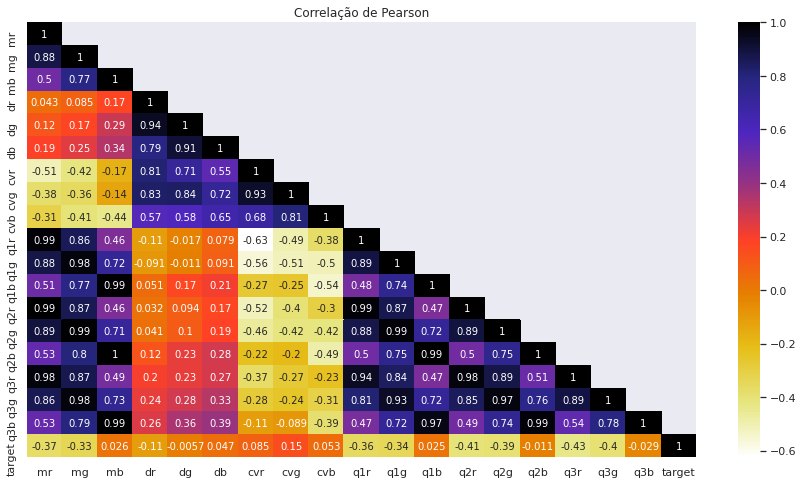

In [ ]:
fig,ax = plt.subplots(figsize=(15,8))
mask = np.triu(np.ones((df.corr().shape)),k=1)
sns.heatmap(df.corr(),annot=True,ax=ax,cmap='CMRmap_r',mask=mask)
plt.title('Correlação de Pearson')
plt.show()

removendo uma das 2 features com correlação maior ou igual a 0.9

In [ ]:
# método responsável por remover uma das 2 features com correlação maior que 0.9
correlation = df.corr()
def selectFeatureByCorr(correlation,df):
  df_correlation = correlation.copy()

  cols = np.full((df_correlation.shape[0],),True, dtype=bool)
  for i in range(df_correlation.shape[0]):
    for j in range(i+1,df_correlation.shape[0]):
      if df_correlation.iloc[i,j] >= 0.9:
        if cols[j]:
          cols[j] = False

  selected_cols = df.columns[cols]
  df = df[selected_cols]

  return df


In [ ]:
df = selectFeatureByCorr(correlation,df)

Variáveis selecionadas





In [ ]:
df.head()

,mr,mg,mb,dr,cvr,cvb,target
48,-0.559590,0.148204,0.908806,-1.105387,-0.951148,-1.354953,6
19,0.369086,0.002074,-0.305543,-0.279812,-0.457286,-0.082223,5
1,0.157451,-0.169407,-0.537104,-0.974088,-0.980881,0.586936,15
25,0.167817,0.380743,1.676989,2.075490,1.583616,0.849317,18
36,0.442224,0.170350,-0.453206,2.551520,1.784229,1.734059,1


# Tunando os hiperparâmetros

**Kernel**

Responsável por selecionar o hiperplano utilizado para separação dos dados.
Os tipos de Kernel são:


*   linear
*   poly (polinomial)
*   rbf (função de base radial)
*   sigmoid


**C**

Responsável por atribuir uma penalidade no termo de erro.
Um valor muito alto pode levar o modelo a um overfitting.

**gamma**


*   Utilizado em hiperplanos NÃO lineares
*   Quanto maior, mais se ajusta ao conjunto de treinamento





In [ ]:
from skopt import BayesSearchCV
model = SVC()

parameters = {'C': [1,2],
              'kernel':['linear','poly','rbf'],
              'degree':[3,4,5],
              'gamma': ['scale','auto'],              
              'probability': [True],
              'decision_function_shape': ['ovo']
              }

opt = BayesSearchCV(model,parameters,n_iter=10,cv=5,return_train_score=True,
                    scoring='precision_macro',refit=True,n_jobs=-1,verbose=1)
opt.fit(x_train, y_train)
y_pred_test = opt.predict(x_test)
y_pred_test_prob = opt.predict(x_test)
print('Optimize Bayes...')
print(opt.best_estimator_)
print(classification_report(y_test,y_pred_test))

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.0s finished


Optimize Bayes...
SVC(C=2, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovo', degree=4, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        17
           1       0.96      1.00      0.98        25
           2       1.00      1.00      1.00        18
           3       1.00      1.00      1.00        20
           4       1.00      1.00      1.00        28
           5       1.00      1.00      1.00        16
           6       1.00      1.00      1.00        16
           7       1.00      1.00      1.00        21
           8       1.00      1.00      1.00        15
           9       1.00      1.00      1.00        19
          10       0.88      0.94      0.91        16
          11       1.00      1.00      1.00        25
          12       1.00      

In [ ]:
1/(6*x_train.var())

0.16329215729443122

In [ ]:
# gamma: scale = 1/(n_features * X.var()) | auto = 1/n_features
def randomize_params(x,y,xtest,ytest):
    model = SVC()
    
    parameters = {'C': [1,2],
                  'kernel':['poly','rbf','linear'],
                  'degree':[3,4,5],
                  'gamma': ['scale','auto'], 
                  'probability': [True],
                  'max_iter': [-1],
                  }
        
    clf = RandomizedSearchCV(model,param_distributions=parameters,scoring='precision_macro',
                             cv=10, n_iter=30,verbose=True,n_jobs=-1)
    search = clf.fit(x,y)
    print(search.best_params_)
    
    y_pred = clf.predict(xtest)
    print(classification_report(y_test,y_pred,target_names=classes_))
randomize_params(x_train,y_train,x_test,y_test)

Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   18.9s


{'probability': True, 'max_iter': -1, 'kernel': 'linear', 'gamma': 'auto', 'degree': 3, 'C': 2}
                  precision    recall  f1-score   support

    angelimPedra       1.00      1.00      1.00        17
   angelimRajado       0.96      1.00      0.98        25
          assacu       1.00      1.00      1.00        18
      cumarurana       1.00      1.00      1.00        20
        guariuba       1.00      1.00      1.00        28
       jacareuba       1.00      1.00      1.00        16
      jutaiMirim       1.00      1.00      1.00        16
      louroAritu       1.00      1.00      1.00        21
     louroGamela       1.00      1.00      1.00        15
     louroItauba       1.00      1.00      1.00        19
       macacauba       0.88      0.94      0.91        16
          marupa       1.00      1.00      1.00        25
       pauMulato       1.00      0.94      0.97        16
       pauRainha       1.00      0.90      0.95        20
         pauRosa       1.00      

[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   30.5s finished


In [ ]:
def plot_confusion_matrix(y_true,y_pred, title=''):
  fig,ax = plt.subplots(figsize=(10,6))
  sns.heatmap(confusion_matrix(y_test,y_pred_test),
              annot=True,ax=ax,fmt='d',square=True,cmap='Blues',cbar=False)
  ax.set_xticklabels([c for c in classes_],rotation=90)
  ax.set_yticklabels([c for c in classes_],rotation=0)
  ax.set_xlabel('Real')
  ax.set_ylabel('Predito')
  ax.set_title('Matriz confusão - {}'.format(title))
  plt.show()                         


30 iterações com 10 folds (kfold)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until



Média da precisão das 30 iterações com kfold=10:  0.99

Métricas para os dados de teste: 
                   precision    recall  f1-score   support

    angelimPedra       1.00      1.00      1.00        17
   angelimRajado       0.96      1.00      0.98        25
          assacu       1.00      1.00      1.00        18
      cumarurana       1.00      1.00      1.00        20
        guariuba       1.00      1.00      1.00        28
       jacareuba       1.00      1.00      1.00        16
      jutaiMirim       1.00      1.00      1.00        16
      louroAritu       1.00      1.00      1.00        21
     louroGamela       1.00      1.00      1.00        15
     louroItauba       1.00      1.00      1.00        19
       macacauba       0.88      0.94      0.91        16
          marupa       1.00      1.00      1.00        25
       pauMulato       1.00      0.94      0.97        16
       pauRainha       1.00      0.90      0.95        20
         pauRosa       1.00      1.00

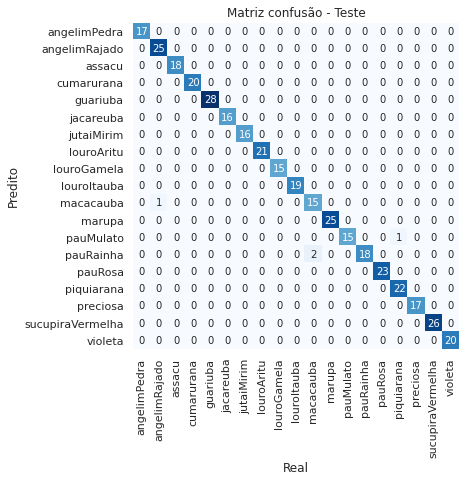

In [ ]:
media = []
media_iter = np.array(())
for i in tqdm(range(30),leave=True,position=0,total=29,desc='30 testes com kfold (10)'):
    from sklearn.model_selection import KFold
    kfold = KFold(n_splits=10,shuffle=True)
    for i_train, i_test in kfold.split(x_train):
        x_trai = x_train[i_train]
        y_trai = y_train[i_train]
        
        x_tes = x_train[i_test]
        y_tes = y_train[i_test]
        
        md = SVC(C=2,kernel='linear')
        md.fit(x_trai,y_trai)
        y_pred = md.predict(x_tes)
        
        media.append(round(precision_score(y_tes,y_pred,average='macro'),2))
        
    media_iter = np.append(media_iter,np.asarray(media).mean())

print('Média da precisão das 30 iterações com kfold=10: ', round(media_iter.mean(),2))

md1 = SVC(C=2,kernel='linear')
md1.fit(x_train,y_train)
y_pred_test = md1.predict(x_test)
print('\nMétricas para os dados de teste: \n',classification_report(y_test,y_pred_test,target_names=classes_))

plot_confusion_matrix(y_test,y_pred_test,'Teste')

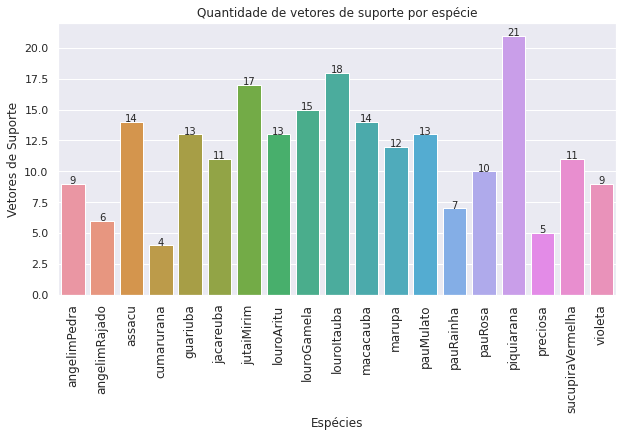

In [ ]:
support_vectors = md1.n_support_
df_support = df_complete.drop_duplicates(subset=['target','especie'])[['target','especie']]
df_support.sort_values(by='target',inplace=True,ignore_index=True)
df_support['qtd_vetores_sup'] = support_vectors
df_support
fig,ax = plt.subplots(figsize=(10,5))
sns.barplot(x='especie',y='qtd_vetores_sup',data=df_support,ax=ax)
ax.set_xticklabels(df_support.especie,rotation=90,size=12)
ax.set_ylabel('Vetores de Suporte')
ax.set_xlabel('Espécies')
for p in ax.patches:
  ax.annotate(format(p.get_height(),'.0f'),
            (p.get_x() + p.get_width() / 2., p.get_height()+0.25),
            va='center',ha='center')
ax.set_title('Quantidade de vetores de suporte por espécie')
plt.show()

In [ ]:
df_complete.head(5)

,mr,mg,mb,dr,dg,db,cvr,cvg,cvb,q1r,q1g,q1b,q2r,q2g,q2b,q3r,q3g,q3b,target,especie
0,189.080694,153.198143,108.234653,16.170381,19.637174,23.817808,8.552106,12.818154,22.005714,180.0,143.0,96.0,188.0,150.0,103.0,195.0,158.0,111.0,8,louroGamela
1,186.407087,147.398192,98.624780,9.237605,9.609596,10.050198,4.955608,6.519480,10.190337,181.0,142.0,93.0,187.0,148.0,99.0,192.0,153.0,103.0,8,louroGamela
2,185.876246,147.070919,97.713294,8.552628,8.424787,8.279538,4.601248,5.728384,8.473297,181.0,142.0,93.0,186.0,147.0,97.0,191.0,152.0,102.0,8,louroGamela
3,185.062610,146.066520,96.125415,7.707624,7.755144,8.112709,4.164874,5.309323,8.439712,180.0,141.0,91.0,186.0,147.0,96.0,190.0,151.0,101.0,8,louroGamela
4,184.775806,145.402590,95.001711,8.079392,8.543806,9.054735,4.372538,5.875965,9.531128,180.0,141.0,90.0,185.0,146.0,95.0,190.0,150.0,100.0,8,louroGamela


In [ ]:
errors = (y_pred_test-y_test != 0)
y_pred_classes_err = y_pred_test[errors]
y_pred_classes_err

array([ 1, 10, 10, 15])

In [ ]:
y_test_err = y_test[errors]
y_test_err

array([10, 13, 13, 12])

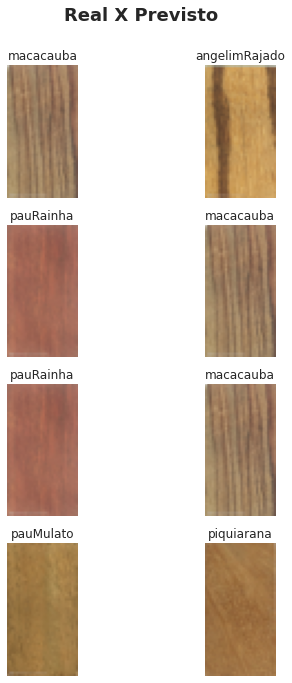

In [ ]:
y_test_err_name = list(map(lambda x: classes_[x],y_test_err))
y_pred_class_err_name = list(map(lambda x: classes_[x],y_pred_classes_err))

list_im = []
name=[]
for _,_,file in os.walk(path):
  for img in file:
    if img.split('.')[1] == 'jpg':
      list_im.append(np.asarray(Image.open(img)))
      name.append(img.split('.')[0])

num_rows = len(y_test_err)
num_cols = 2 

fig, ax = plt.subplots(nrows=num_rows,ncols=num_cols,figsize=(7,9))
fig.suptitle('Real X Previsto\n\n\n',size=18, y =1.05,fontweight='black')
fig.subplots_adjust(top=0.8)
for index in range(len(y_test_err)):
  index_true = [i for i,x in enumerate(name) if x == y_test_err_name[index]]
  index_predict = [i for i,x in enumerate(name) if x == y_pred_class_err_name[index]]  
  im_true = Image.fromarray(list_im[index_true[0]])  
  im_predict = Image.fromarray(list_im[index_predict[0]])
  ax[index,0].imshow(im_true.resize((32,60)))
  ax[index,0].set_title(name[index_true[0]])
  ax[index,1].imshow(im_predict.resize((32,60)))
  ax[index,1].set_title(name[index_predict[0]])
  ax[index,0].axis('off')
  ax[index,1].axis('off')
plt.tight_layout()
plt.show()


Aplicando modelo nos dados de validação

              precision    recall  f1-score   support

           0       0.93      1.00      0.96        13
           1       0.88      0.88      0.88         8
           2       1.00      1.00      1.00         8
           3       1.00      0.91      0.95        11
           4       1.00      1.00      1.00         6
           5       1.00      1.00      1.00        14
           6       0.92      0.92      0.92        13
           7       1.00      0.92      0.96        12
           8       1.00      1.00      1.00        13
           9       0.92      1.00      0.96        12
          10       1.00      1.00      1.00        11
          11       1.00      1.00      1.00         6
          12       1.00      1.00      1.00        10
          13       1.00      1.00      1.00        14
          14       1.00      1.00      1.00         6
          15       1.00      1.00      1.00        11
          16       1.00      1.00      1.00         8
          17       1.00    

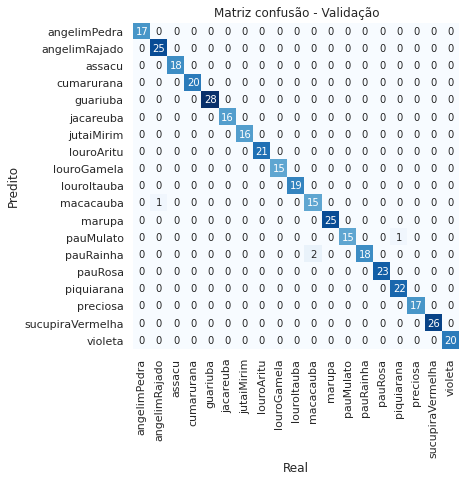

In [ ]:
y_pred_val = md1.predict(x_val)
print(classification_report(y_val,y_pred_val))
plot_confusion_matrix(y_val,y_pred_val,'Validação')